# Original ADS

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# MAIN_PATH = '../input/'
df = pd.read_csv('bank_data.csv')
term_deposits = df.copy()
# Have a grasp of how our data looks.
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [3]:
from sklearn.model_selection import StratifiedShuffleSplit
# Here we split the data into training and test sets and implement a stratified shuffle split.
stratified = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_set, test_set in stratified.split(term_deposits, term_deposits["loan"]):
    stratified_train = term_deposits.loc[train_set]
    stratified_test = term_deposits.loc[test_set]
    
stratified_train["loan"].value_counts()/len(df)
stratified_test["loan"].value_counts()/len(df)

no     0.173894
yes    0.026160
Name: loan, dtype: float64

In [4]:
# Separate the labels and the features.
train_data = stratified_train # Make a copy of the stratified training set.
test_data = stratified_test
train_data.shape
test_data.shape
train_data['deposit'].value_counts()

no     4697
yes    4232
Name: deposit, dtype: int64

In [5]:
# Definition of the CategoricalEncoder class, copied from PR #9151.
# Just run this cell, or copy it to your code, no need to try to
# understand every line.
# Code reference Hands on Machine Learning with Scikit Learn and Tensorflow by Aurelien Geron.

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]
        #print(f"Label encoded: ", self.categories_)
        #print([le.inverse_transform() for le in self._label_encoders_])

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])
            print(f"Label encoded: ", np.unique(X_int[:,i]))
            print(f"Label actual: ", self._label_encoders_[i].inverse_transform(np.unique(X_int[:,i])))

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Making pipelines
numerical_pipeline = Pipeline([
    ("select_numeric", DataFrameSelector(["age", "balance", "day", "campaign", "pdays", "previous","duration"])),
    ("std_scaler", StandardScaler()),
])

categorical_pipeline = Pipeline([
    ("select_cat", DataFrameSelector(["job", "education", "marital", "default", "housing", "loan", "contact", "month",
                                     "poutcome"])),
    ("cat_encoder", CategoricalEncoder(encoding='onehot-dense'))
])

from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("numerical_pipeline", numerical_pipeline),
        ("categorical_pipeline", categorical_pipeline),
    ])

In [8]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

<ipython-input-5-f82235070508>:112: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
<ipython-input-5-f82235070508>:149: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
<ipython-input-5-f82235070508>:151: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not mo

Label encoded:  [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label actual:  ['admin.' 'blue-collar' 'entrepreneur' 'housemaid' 'management' 'retired'
 'self-employed' 'services' 'student' 'technician' 'unemployed' 'unknown']
Label encoded:  [0 1 2 3]
Label actual:  ['primary' 'secondary' 'tertiary' 'unknown']
Label encoded:  [0 1 2]
Label actual:  ['divorced' 'married' 'single']
Label encoded:  [0 1]
Label actual:  ['no' 'yes']
Label encoded:  [0 1]
Label actual:  ['no' 'yes']
Label encoded:  [0 1]
Label actual:  ['no' 'yes']
Label encoded:  [0 1 2]
Label actual:  ['cellular' 'telephone' 'unknown']
Label encoded:  [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label actual:  ['apr' 'aug' 'dec' 'feb' 'jan' 'jul' 'jun' 'mar' 'may' 'nov' 'oct' 'sep']
Label encoded:  [0 1 2 3]
Label actual:  ['failure' 'other' 'success' 'unknown']


array([[ 1.14643868,  1.68761105,  1.69442818, ...,  0.        ,
         0.        ,  1.        ],
       [-0.86102339, -0.35066205, -0.5560058 , ...,  0.        ,
         0.        ,  1.        ],
       [-0.94466765, -0.20504785,  0.39154535, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.86102339, -0.26889658, -1.02978138, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.2263519 , -0.32166951,  0.50998924, ...,  0.        ,
         0.        ,  1.        ],
       [-0.61009063, -0.34740446,  1.69442818, ...,  1.        ,
         0.        ,  0.        ]])

In [9]:
y_train = train_data['deposit']
y_test = test_data['deposit']
y_train.shape

(8929,)

In [10]:
from sklearn.preprocessing import LabelEncoder

encode = LabelEncoder()
y_train = encode.fit_transform(y_train)
y_test = encode.fit_transform(y_test)
y_train_yes = (y_train == 1)
y_train
y_train_yes

array([False, False,  True, ...,  True,  True, False])

In [11]:
# Time for Classification Models
import time


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB


dict_classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Nearest Neighbors": KNeighborsClassifier(),
    "Linear SVM": SVC(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "Decision Tree": tree.DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=18),
    "Neural Net": MLPClassifier(alpha=1),
    "Naive Bayes": GaussianNB()
}

In [12]:
#  Thanks to Ahspinar for the function. 
import time
no_classifiers = len(dict_classifiers.keys())

def batch_classify(X_train, Y_train, verbose = True):
    df_results = pd.DataFrame(data=np.zeros(shape=(no_classifiers,3)), columns = ['classifier', 'train_score', 'training_time'])
    count = 0
    for key, classifier in dict_classifiers.items():
        t_start = time.perf_counter()
        classifier.fit(X_train, Y_train)
        t_end = time.perf_counter()
        t_diff = t_end - t_start
        train_score = classifier.score(X_train, Y_train)
        df_results.loc[count,'classifier'] = key
        df_results.loc[count,'train_score'] = train_score
        df_results.loc[count,'training_time'] = t_diff
        if verbose:
            print("trained {c} in {f:.2f} s".format(c=key, f=t_diff))
        count+=1
    return df_results

In [13]:
df_results = batch_classify(X_train, y_train)
print(df_results.sort_values(by='train_score', ascending=False))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


trained Logistic Regression in 0.59 s
trained Nearest Neighbors in 0.01 s
trained Linear SVM in 7.16 s
trained Gradient Boosting Classifier in 3.28 s
trained Decision Tree in 0.25 s
trained Random Forest in 0.48 s
trained Neural Net in 14.37 s
trained Naive Bayes in 0.03 s
                     classifier  train_score  training_time
4                 Decision Tree     1.000000       0.252277
5                 Random Forest     0.997088       0.481511
2                    Linear SVM     0.881958       7.158149
1             Nearest Neighbors     0.863255       0.005112
3  Gradient Boosting Classifier     0.861463       3.284923
6                    Neural Net     0.855863      14.372982
0           Logistic Regression     0.830776       0.591270
7                   Naive Bayes     0.721693       0.026701


In [14]:
# Use Cross-validation.
from sklearn.model_selection import cross_val_score

# Logistic Regression
log_reg = LogisticRegression()
log_scores = cross_val_score(log_reg, X_train, y_train, cv=3)
log_reg_mean = log_scores.mean()

# SVC
svc_clf = SVC()
svc_scores = cross_val_score(svc_clf, X_train, y_train, cv=3)
svc_mean = svc_scores.mean()

# KNearestNeighbors
knn_clf = KNeighborsClassifier()
knn_scores = cross_val_score(knn_clf, X_train, y_train, cv=3)
knn_mean = knn_scores.mean()

# Decision Tree
tree_clf = tree.DecisionTreeClassifier()
tree_scores = cross_val_score(tree_clf, X_train, y_train, cv=3)
tree_mean = tree_scores.mean()

# Gradient Boosting Classifier
grad_clf = GradientBoostingClassifier()
grad_scores = cross_val_score(grad_clf, X_train, y_train, cv=3)
grad_mean = grad_scores.mean()

# Random Forest Classifier
rand_clf = RandomForestClassifier(n_estimators=18)
rand_scores = cross_val_score(rand_clf, X_train, y_train, cv=3)
rand_mean = rand_scores.mean()

# NeuralNet Classifier
neural_clf = MLPClassifier(alpha=1)
neural_scores = cross_val_score(neural_clf, X_train, y_train, cv=3)
neural_mean = neural_scores.mean()

# Naives Bayes
nav_clf = GaussianNB()
nav_scores = cross_val_score(nav_clf, X_train, y_train, cv=3)
nav_mean = neural_scores.mean()

# Create a Dataframe with the results.
d = {'Classifiers': ['Logistic Reg.', 'SVC', 'KNN', 'Dec Tree', 'Grad B CLF', 'Rand FC', 'Neural Classifier', 'Naives Bayes'], 
    'Crossval Mean Scores': [log_reg_mean, svc_mean, knn_mean, tree_mean, grad_mean, rand_mean, neural_mean, nav_mean]}

result_df = pd.DataFrame(data=d)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [15]:
# All our models perform well but I will go with GradientBoosting.
result_df = result_df.sort_values(by=['Crossval Mean Scores'], ascending=False)
result_df

,Classifiers,Crossval Mean Scores
1,SVC,0.851831
6,Neural Classifier,0.848807
7,Naives Bayes,0.848807
4,Grad B CLF,0.844440
5,Rand FC,0.836039
0,Logistic Reg.,0.828536
2,KNN,0.804569
3,Dec Tree,0.785082


In [16]:
  # Cross validate our Gradient Boosting Classifier
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(grad_clf, X_train, y_train, cv=3)

In [17]:
from sklearn.metrics import accuracy_score
grad_clf.fit(X_train, y_train)
print ("Gradient Boost Classifier accuracy is %2.2f" % accuracy_score(y_train, y_train_pred))

Gradient Boost Classifier accuracy is 0.84


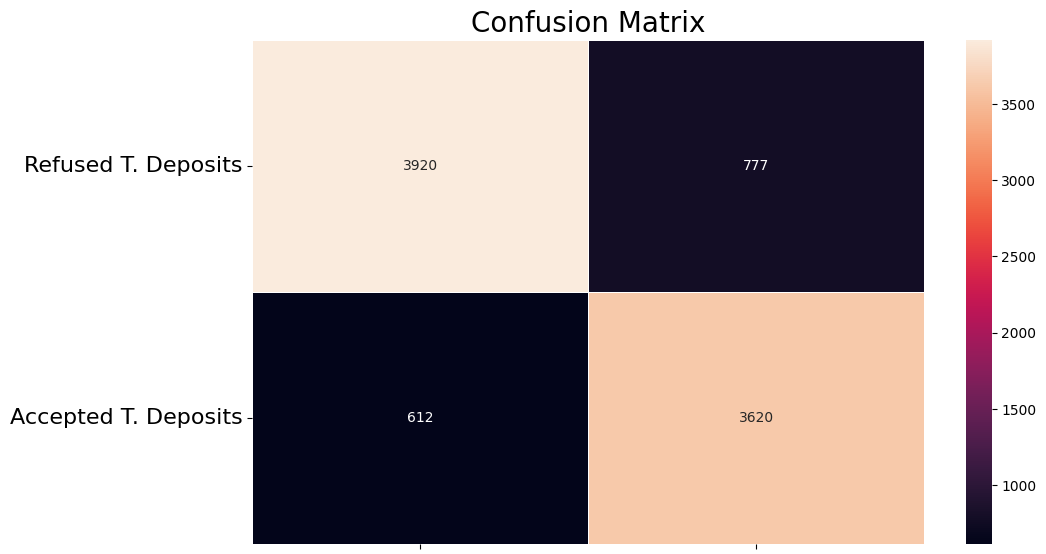

In [18]:
from sklearn.metrics import confusion_matrix
# 4697: no's, 4232: yes
conf_matrix = confusion_matrix(y_train, y_train_pred)
f, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, ax=ax)
plt.title("Confusion Matrix", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels("")
ax.set_yticklabels(['Refused T. Deposits', 'Accepted T. Deposits'], fontsize=16, rotation=360)
plt.show()

In [19]:
# Let's find the scores  for precision and recall.
from sklearn.metrics import precision_score, recall_score
# The model is 77% sure that the potential client will suscribe to a term deposit. 
# The model is only retaining 60% of clients that agree to suscribe a term deposit.
print('Precision Score: ', precision_score(y_train, y_train_pred))
# The classifier only detects 60% of potential clients that will suscribe to a term deposit.
print('Recall Score: ', recall_score(y_train, y_train_pred))

Precision Score:  0.8232886058676371
Recall Score:  0.8553875236294896


In [20]:
from sklearn.metrics import f1_score

f1_score(y_train, y_train_pred)

0.8390311739483138

In [21]:
y_scores = cross_val_predict(grad_clf, X_train, y_train, cv=3, method="decision_function")
neural_y_scores = cross_val_predict(neural_clf, X_train, y_train, cv=3, method="predict_proba")
naives_y_scores = cross_val_predict(nav_clf, X_train, y_train, cv=3, method="predict_proba")

In [22]:
# hack to work around issue #9589 introduced in Scikit-Learn 0.19.0
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

if neural_y_scores.ndim == 2:
    neural_y_scores = neural_y_scores[:, 1]
    
if naives_y_scores.ndim == 2:
    naives_y_scores = naives_y_scores[:, 1]

In [23]:
# How can we decide which threshold to use? We want to return the scores instead of predictions with this code.
from sklearn.metrics import precision_recall_curve

precisions, recalls, threshold = precision_recall_curve(y_train, y_scores)

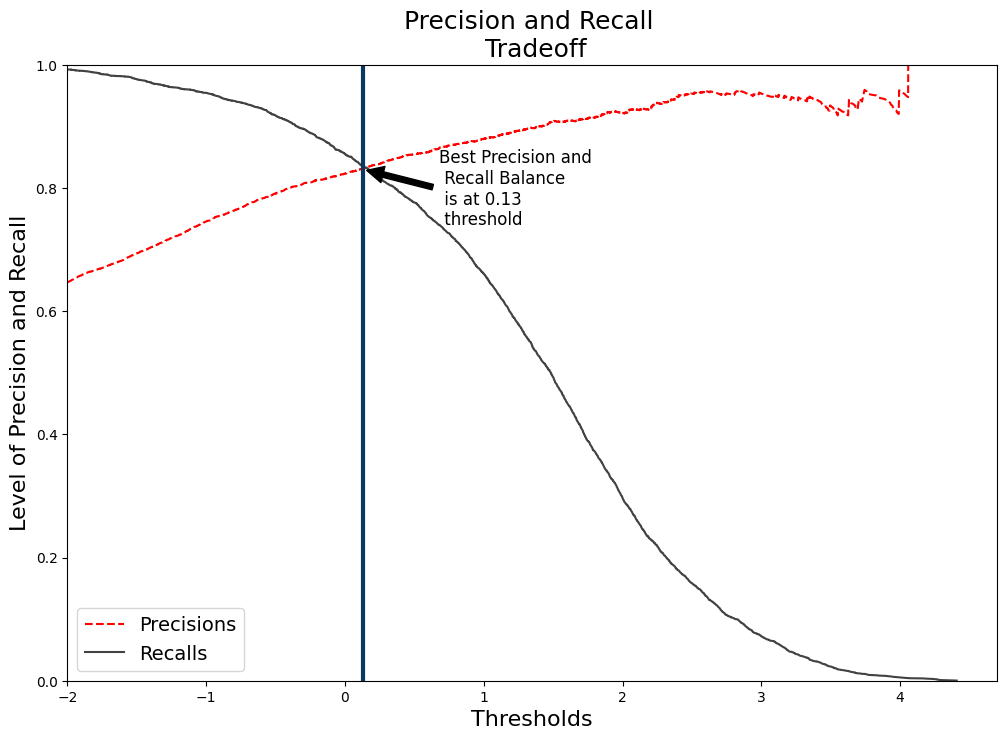

In [24]:
def precision_recall_curve(precisions, recalls, thresholds):
    fig, ax = plt.subplots(figsize=(12,8))
    plt.plot(thresholds, precisions[:-1], "r--", label="Precisions")
    plt.plot(thresholds, recalls[:-1], "#424242", label="Recalls")
    plt.title("Precision and Recall \n Tradeoff", fontsize=18)
    plt.ylabel("Level of Precision and Recall", fontsize=16)
    plt.xlabel("Thresholds", fontsize=16)
    plt.legend(loc="best", fontsize=14)
    plt.xlim([-2, 4.7])
    plt.ylim([0, 1])
    plt.axvline(x=0.13, linewidth=3, color="#0B3861")
    plt.annotate('Best Precision and \n Recall Balance \n is at 0.13 \n threshold ', xy=(0.13, 0.83), xytext=(55, -40),
             textcoords="offset points",
            arrowprops=dict(facecolor='black', shrink=0.05),
                fontsize=12, 
                color='k')
    
precision_recall_curve(precisions, recalls, threshold)
plt.show()

In [25]:
from sklearn.metrics import roc_curve
# Gradient Boosting Classifier
# Neural Classifier
# Naives Bayes Classifier
grd_fpr, grd_tpr, thresold = roc_curve(y_train, y_scores)
neu_fpr, neu_tpr, neu_threshold = roc_curve(y_train, neural_y_scores)
nav_fpr, nav_tpr, nav_threshold = roc_curve(y_train, naives_y_scores)

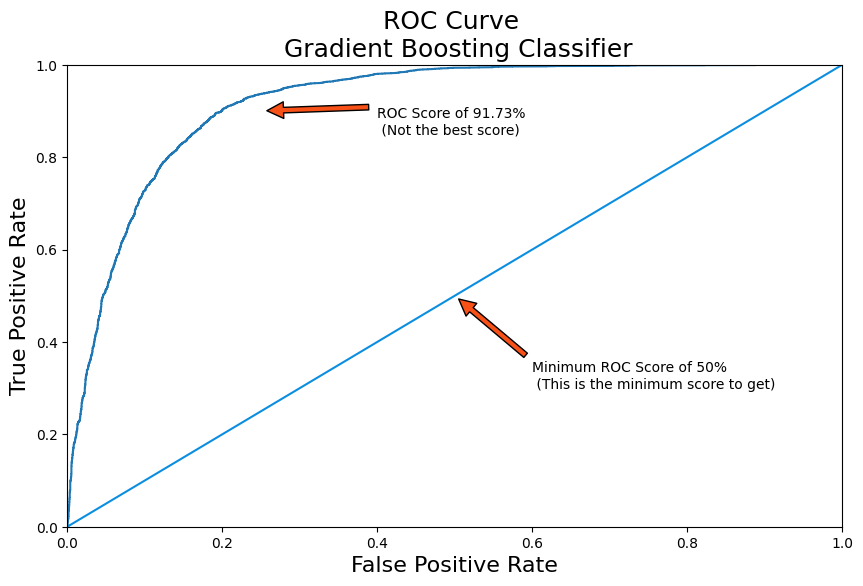

In [26]:
def graph_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.figure(figsize=(10,6))
    plt.title('ROC Curve \n Gradient Boosting Classifier', fontsize=18)
    plt.plot(false_positive_rate, true_positive_rate, label=label)
    plt.plot([0, 1], [0, 1], '#0C8EE0')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('ROC Score of 91.73% \n (Not the best score)', xy=(0.25, 0.9), xytext=(0.4, 0.85),
            arrowprops=dict(facecolor='#F75118', shrink=0.05),
            )
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#F75118', shrink=0.05),
                )
    
    
graph_roc_curve(grd_fpr, grd_tpr, threshold)
plt.show()

In [27]:
from sklearn.metrics import roc_auc_score

print('Gradient Boost Classifier Score: ', roc_auc_score(y_train, y_scores))
print('Neural Classifier Score: ', roc_auc_score(y_train, neural_y_scores))
print('Naives Bayes Classifier: ', roc_auc_score(y_train, naives_y_scores))

Gradient Boost Classifier Score:  0.9173805485784475
Neural Classifier Score:  0.916630562563966
Naives Bayes Classifier:  0.803352414343226


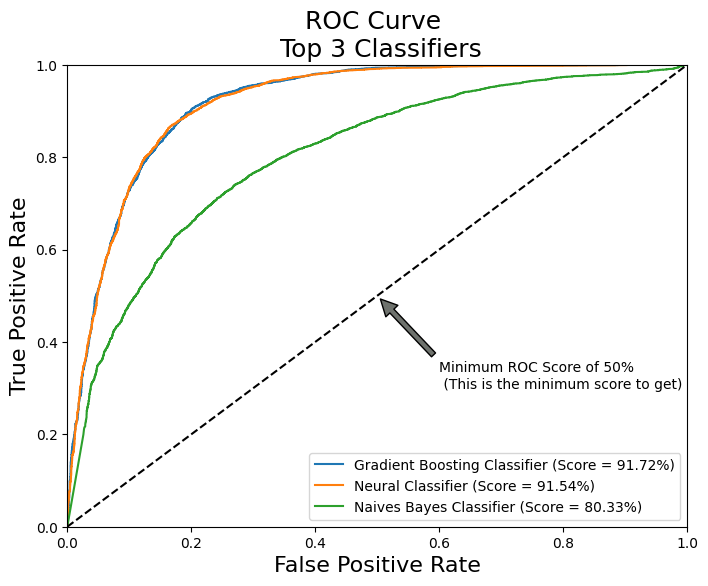

In [28]:
def graph_roc_curve_multiple(grd_fpr, grd_tpr, neu_fpr, neu_tpr, nav_fpr, nav_tpr):
    plt.figure(figsize=(8,6))
    plt.title('ROC Curve \n Top 3 Classifiers', fontsize=18)
    plt.plot(grd_fpr, grd_tpr, label='Gradient Boosting Classifier (Score = 91.72%)')
    plt.plot(neu_fpr, neu_tpr, label='Neural Classifier (Score = 91.54%)')
    plt.plot(nav_fpr, nav_tpr, label='Naives Bayes Classifier (Score = 80.33%)')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(grd_fpr, grd_tpr, neu_fpr, neu_tpr, nav_fpr, nav_tpr)
plt.show()

<ipython-input-29-cd94fcf4b732>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


Feature ranking:
1. feature 11 (0.591310)
2. feature 8 (0.129966)
3. feature 6 (0.067020)
4. feature 13 (0.049923)
5. feature 15 (0.038138)
6. feature 14 (0.037830)
7. feature 10 (0.026646)
8. feature 5 (0.025842)
9. feature 0 (0.017757)
10. feature 12 (0.007889)
11. feature 3 (0.005280)
12. feature 9 (0.002200)
13. feature 2 (0.000147)
14. feature 1 (0.000050)
15. feature 7 (0.000000)
16. feature 4 (0.000000)


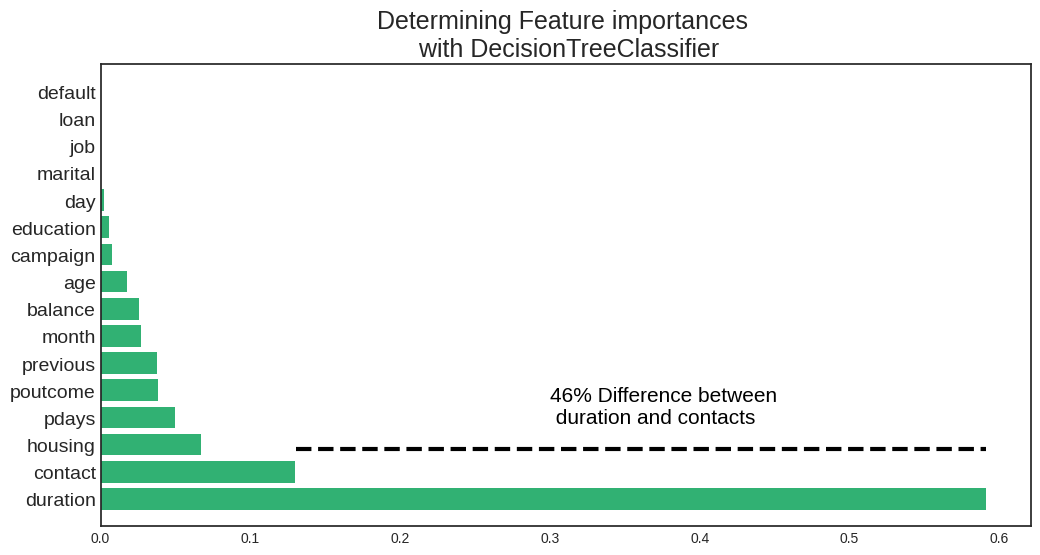

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
plt.style.use('seaborn-white')

# Convert the columns into categorical variables
term_deposits['job'] = term_deposits['job'].astype('category').cat.codes
term_deposits['marital'] = term_deposits['marital'].astype('category').cat.codes
term_deposits['education'] = term_deposits['education'].astype('category').cat.codes
term_deposits['contact'] = term_deposits['contact'].astype('category').cat.codes
term_deposits['poutcome'] = term_deposits['poutcome'].astype('category').cat.codes
term_deposits['month'] = term_deposits['month'].astype('category').cat.codes
term_deposits['default'] = term_deposits['default'].astype('category').cat.codes
term_deposits['loan'] = term_deposits['loan'].astype('category').cat.codes
term_deposits['housing'] = term_deposits['housing'].astype('category').cat.codes

# Let's create new splittings like before but now we modified the data so we need to do it one more time.
# Create train and test splits
target_name = 'deposit'
X = term_deposits.drop('deposit', axis=1)


label=term_deposits[target_name]

X_train, X_test, y_train, y_test = train_test_split(X,label,test_size=0.2, random_state=42, stratify=label)

# Build a classification task using 3 informative features
tree = tree.DecisionTreeClassifier(
    class_weight='balanced',
    min_weight_fraction_leaf = 0.01
    
)



tree = tree.fit(X_train, y_train)
importances = tree.feature_importances_
feature_names = term_deposits.drop('deposit', axis=1).columns
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
def feature_importance_graph(indices, importances, feature_names):
    plt.figure(figsize=(12,6))
    plt.title("Determining Feature importances \n with DecisionTreeClassifier", fontsize=18)
    plt.barh(range(len(indices)), importances[indices], color='#31B173',  align="center")
    plt.yticks(range(len(indices)), feature_names[indices], rotation='horizontal',fontsize=14)
    plt.ylim([-1, len(indices)])
    plt.axhline(y=1.85, xmin=0.21, xmax=0.952, color='k', linewidth=3, linestyle='--')
    plt.text(0.30, 2.8, '46% Difference between \n duration and contacts', color='k', fontsize=15)
    
feature_importance_graph(indices, importances, feature_names)
plt.show()

In [30]:
# Our three classifiers are grad_clf, nav_clf and neural_clf
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[('gbc', grad_clf), ('nav', nav_clf), ('neural', neural_clf)],
    voting='soft'
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('gbc', GradientBoostingClassifier()),
                             ('nav', GaussianNB()),
                             ('neural', MLPClassifier(alpha=1))],
                 voting='soft')

In [31]:
from sklearn.metrics import accuracy_score

for clf in (grad_clf, nav_clf, neural_clf, voting_clf):
    clf.fit(X_train, y_train)
    predict = clf.predict(X_test)
    print(predict)
    print(clf.__class__.__name__, accuracy_score(y_test, predict))

['yes' 'yes' 'yes' ... 'yes' 'yes' 'yes']
GradientBoostingClassifier 0.8463949843260188
['yes' 'yes' 'yes' ... 'no' 'yes' 'no']
GaussianNB 0.7514554411106136
['yes' 'yes' 'no' ... 'no' 'yes' 'no']
MLPClassifier 0.7201074787281684
['yes' 'yes' 'yes' ... 'yes' 'yes' 'no']
VotingClassifier 0.8096730855351545


In [32]:
grad_clf.fit(X_train, y_train)

GradientBoostingClassifier()

In [33]:
predict = grad_clf.predict(X_test)

In [34]:
predict

array(['yes', 'yes', 'yes', ..., 'yes', 'yes', 'yes'], dtype=object)

(array([1117.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1116.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

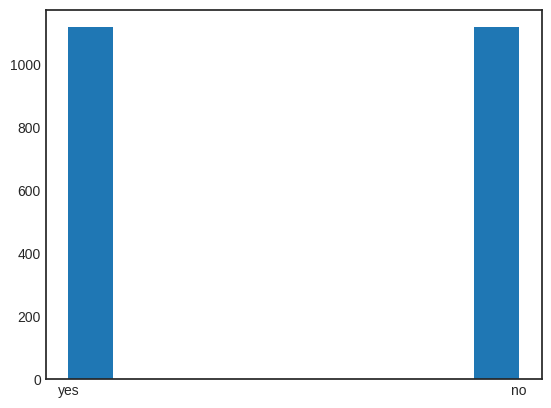

In [35]:
plt.hist(predict)

# Robustness check for duration feature

In [36]:
X_test.to_csv('X_test.csv', index=False)

In [37]:
pd.DataFrame(predict).to_csv('y_pred.csv', index=False)

In [38]:
y_test.to_csv('y_test.csv', index=False)

In [39]:
y_test.to_csv('y_test.csv', index=False)
predict=pd.Series(predict)

In [40]:
y_pred=predict.apply(lambda x:1 if x=='yes' else 0)
y_test=y_test.apply(lambda x:1 if x=='yes' else 0)

In [41]:
X_test1 = X_test.copy()
X_test1['duration']=X_test['duration'] = 0
# X_test1=X_test1.drop('age_cat', axis=1)
pred1 = grad_clf.predict(X_test1)

In [42]:
# Map string labels to integer labels in pred1
label_mapping = {'no': 0, 'yes': 1}
pred1_int = [label_mapping[label] for label in pred1]

# Calculate accuracy
accuracy = accuracy_score(y_test, pred1_int)
print("Accuracy:", accuracy)

Accuracy: 0.5432154052843708


# Fairness metrics Calculation using Fairlearn

In [43]:
%%capture
#@markdown

!pip install fairlearn
!pip install folktables

#ask Lucas if superquail is needed
!git clone https://github.com/lurosenb/superquail
    


In [44]:
!pip install matplotlib==3.4.1 --force-reinstall  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 22.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.7/247.7 kB 12.5 MB/s eta 0:00:00
  Created wheel for matplotlib: filename=matplotlib-3.4.1-cp310-cp310-linux_x86_64.whl size=10514237 sha256=261dadb83510cc0a97108759d905ed5f87e6cf6c060059275c743ed688e6f4e1
  Stored in directory: /root/.cache/pip/wheels/4d/84/33/44631b04443c528df9a892f4f274e319c81c8b15fa6c37bb4c
Successfully built matplotlib
  Attempting uninstall: six
    Found existing installation: six 1.16

In [45]:
#@markdown
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as skm
from sklearn.model_selection import cross_val_score
import matplotlib.ticker as ticker



from fairlearn.metrics import MetricFrame
from fairlearn.metrics import demographic_parity_difference, demographic_parity_ratio, selection_rate_difference, equalized_odds_ratio, false_negative_rate_difference, false_positive_rate_difference, selection_rate
from fairlearn.metrics import false_negative_rate, false_positive_rate

from IPython.display import clear_output 

In [46]:
X_test['education'].dtype
len(X_test)
#y_test[np.where(X_test['education']==0)[0]]
X_test['education'].value_counts()
#y_test.shape

1    1119
2     732
0     299
3      83
Name: education, dtype: int64

###Calculating the Fairness Metrics across the sensitive feature - education

In [47]:
#Getting the Fairness metrics for each sensitive feature-
#compute demographic parity difference and demographic parity ratio
demo_parity_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=X_test['education'])
demo_parity_ratio = demographic_parity_ratio(y_test, y_pred, sensitive_features=X_test['education'])

selection_rate_diff = selection_rate_difference(y_test, y_pred, sensitive_features=X_test['education'])
equalized_odds_r = equalized_odds_ratio(y_test, y_pred, sensitive_features=X_test['education'])

false_negative_rate_diff = false_negative_rate_difference(y_test, y_pred, sensitive_features=X_test['education'])
false_positive_rate_diff = false_positive_rate_difference(y_test, y_pred, sensitive_features=X_test['education'])

print(f'Selection Rate difference: {selection_rate_diff:.4f}')
print(f'Equalized odds ratio: {equalized_odds_r:.4f}')

print(f'False negative rate difference: {false_negative_rate_diff:.4f}')
print(f'flase positive rate diff: {false_positive_rate_diff:.4f}')

print(f'Demographic parity difference: {demo_parity_diff:.4f}')
print(f'Demographic parity ratio: {demo_parity_ratio:.4f}')

#compute selection rate for males and females
# primary_selection_rate = selection_rate(y_test[X_test['education']==0], y_pred[np.where(X_test['education']==0)[0]])
# secondary_selection_rate = selection_rate(y_test[X_test['education']==1], y_pred[np.where(X_test['education']==1)[0]])
# tertiary_selection_rate = selection_rate(y_test[X_test['education']==2], y_pred[np.where(X_test['education']==2)[0]])
# unknown_selection_rate = selection_rate(y_test[X_test['education']==3], y_pred[np.where(X_test['education']==3)[0]])

# print(f'Primary selection rate: {primary_selection_rate:.4f}')
# print(f'Secondary selection rate: {secondary_selection_rate:.4f}')
# print(f'Tertiary selection rate: {tertiary_selection_rate:.4f}')
# print(f'Unknown selection rate: {unknown_selection_rate:.4f}')

Selection Rate difference: 0.1909
Equalized odds ratio: 0.3571
False negative rate difference: 0.0763
flase positive rate diff: 0.1646
Demographic parity difference: 0.1909
Demographic parity ratio: 0.6794


In [48]:
X_test['marital'].value_counts()

1    1307
2     661
0     265
Name: marital, dtype: int64

### Calculating the Fairness Metrics across the sensitive feature - marital status

In [49]:
#Getting the Fairness metrics for each sensitive feature-
#compute demographic parity difference and demographic parity ratio
demo_parity_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=X_test['marital'])
demo_parity_ratio = demographic_parity_ratio(y_test, y_pred, sensitive_features=X_test['marital'])

print(f'Demographic parity difference: {demo_parity_diff:.4f}')
print(f'Demographic parity ratio: {demo_parity_ratio:.4f}')

selection_rate_diff = selection_rate_difference(y_test, y_pred, sensitive_features=X_test['marital'])
equalized_odds_r = equalized_odds_ratio(y_test, y_pred, sensitive_features=X_test['marital'])

false_negative_rate_diff = false_negative_rate_difference(y_test, y_pred, sensitive_features=X_test['marital'])
false_positive_rate_diff = false_positive_rate_difference(y_test, y_pred, sensitive_features=X_test['marital'])

print(f'Selection Rate difference: {selection_rate_diff:.4f}')
print(f'Equalized odds ratio: {equalized_odds_r:.4f}')

print(f'False negative rate difference: {false_negative_rate_diff:.4f}')
print(f'flase positive rate diff: {false_positive_rate_diff:.4f}')

#compute selection rate for males and females
# married_selection_rate = selection_rate(y_test[X_test['marital']==1], y_pred[np.where(X_test['marital']==1)[0]])
# divorced_selection_rate = selection_rate(y_test[X_test['marital']==0], y_pred[np.where(X_test['marital']==0)[0]])
# single_selection_rate = selection_rate(y_test[X_test['marital']==2], y_pred[np.where(X_test['marital']==2)[0]])

# print(f'Married selection rate: {married_selection_rate:.4f}')
# print(f'Divorced selection rate: {divorced_selection_rate:.4f}')
# print(f'Single selection rate: {single_selection_rate:.4f}')


Demographic parity difference: 0.1196
Demographic parity ratio: 0.7942
Selection Rate difference: 0.1196
Equalized odds ratio: 0.6423
False negative rate difference: 0.0383
flase positive rate diff: 0.0754


In [50]:
#Evaluate the fairness of the classifier using the MetricFrame class for the `Education` variable

#changing sensitive feature inputs to be 'male' and 'female' instead of 1 and 0
sensitive_feature_e = X_test['education'].replace({0:'primary', 1:'tertiary', 2: 'secondary', 3:'unknown'})

#evaluation metrics
metrics = {'accuracy': skm.accuracy_score,
           'selection_rate': selection_rate,  # i.e., the percentage of the population which have ‘1’ as their predicted label
           'FNR': false_negative_rate,
           'FPR': false_positive_rate,
           'Recall': recall_score,
           'F1 Score': f1_score,
           'Precision': precision_score
           }
           

grouped_on_edu = MetricFrame(metrics=metrics,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_feature_e)

In [51]:
grouped_on_edu.by_group

,accuracy,selection_rate,FNR,FPR,Recall,F1 Score,Precision
education,,,,,,,
primary,0.882943,0.404682,0.153226,0.091429,0.846774,0.857143,0.867769
secondary,0.816940,0.595628,0.122500,0.256024,0.877500,0.839713,0.805046
tertiary,0.857015,0.458445,0.143434,0.142628,0.856566,0.841270,0.826511
unknown,0.831325,0.566265,0.076923,0.250000,0.923077,0.837209,0.765957


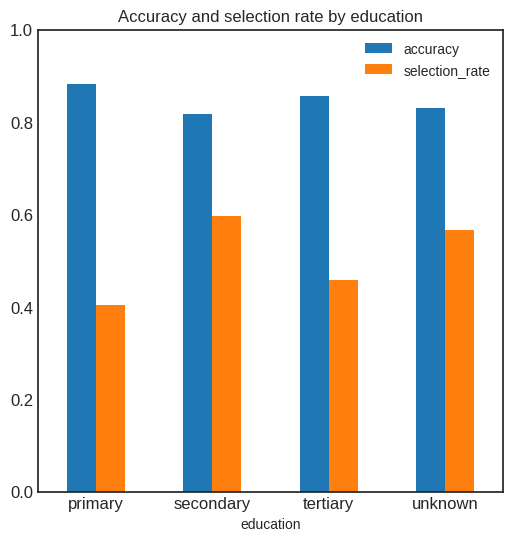

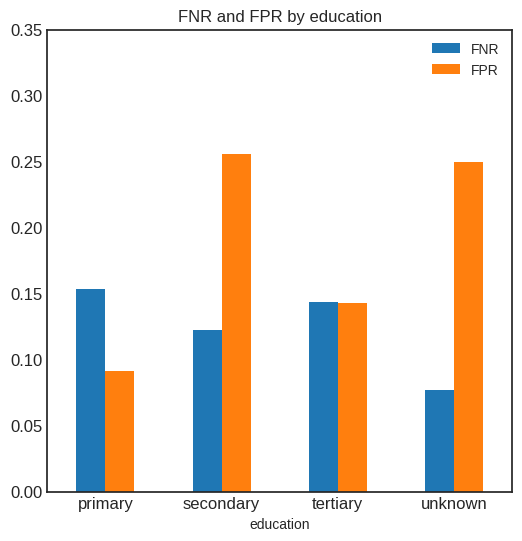

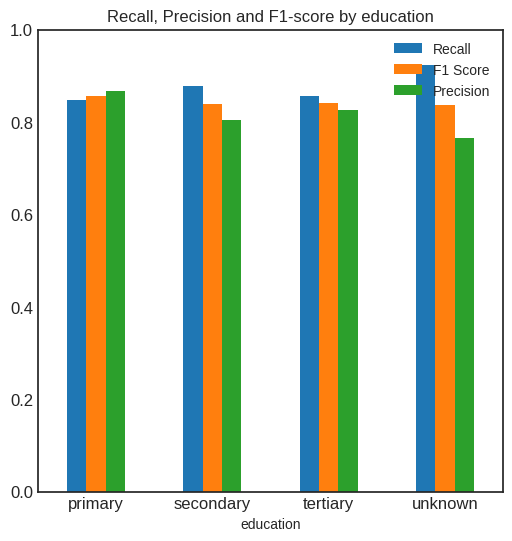

In [52]:
# Plot the metric values

metrics_1 = {'accuracy': skm.accuracy_score,
           'selection_rate': selection_rate,  # i.e., the percentage of the population which have ‘1’ as their predicted label
           }

metrics_2 = {
           'FNR': false_negative_rate,
           'FPR': false_positive_rate
           }

metrics_3 = {
           'Recall': recall_score,
           'F1 Score': f1_score,
           'Precision': precision_score
           }

grouped_on_edu_accuracy_selection = MetricFrame(metrics=metrics_1,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_feature_e)

grouped_on_edu_fpr_fnr = MetricFrame(metrics=metrics_2,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_feature_e)

grouped_on_edu_rec = MetricFrame(metrics=metrics_3,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_feature_e)

grouped_on_edu_accuracy_selection.by_group.plot.bar(
    subplots=False, 
    figsize=(6,6), 
    ylim=[0,1],
    title="Accuracy and selection rate by education",
    )

plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

grouped_on_edu_fpr_fnr.by_group.plot.bar(
    subplots=False, 
    figsize=(6, 6), 
    ylim=[0,0.35],
    title="FNR and FPR by education",
    )

plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

grouped_on_edu_rec.by_group.plot.bar(
    subplots=False, 
    figsize=(6,6), 
    ylim=[0,1],
    title="Recall, Precision and F1-score by education",
    )

plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [53]:
#Evaluate the fairness of the classifier using the MetricFrame class for the `Marital` variable

sensitive_feature_m = X_test['marital'].replace({0:'divorced', 1:'married', 2: 'single'})

#evaluation metrics
metrics = {'accuracy': skm.accuracy_score,
           'selection_rate': selection_rate,  # i.e., the percentage of the population which have ‘1’ as their predicted label
           'FNR': false_negative_rate,
           'FPR': false_positive_rate,
           'Recall': recall_score,
           'F1 Score': f1_score,
           'Precision': precision_score
           }
           

grouped_on_marital = MetricFrame(metrics=metrics,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_feature_m)

In [54]:
grouped_on_marital.by_group

,accuracy,selection_rate,FNR,FPR,Recall,F1 Score,Precision
marital,,,,,,,
divorced,0.856604,0.490566,0.151515,0.135338,0.848485,0.854962,0.861538
married,0.846213,0.461362,0.143617,0.161507,0.856383,0.827763,0.800995
single,0.842663,0.580938,0.113260,0.210702,0.886740,0.860590,0.835938


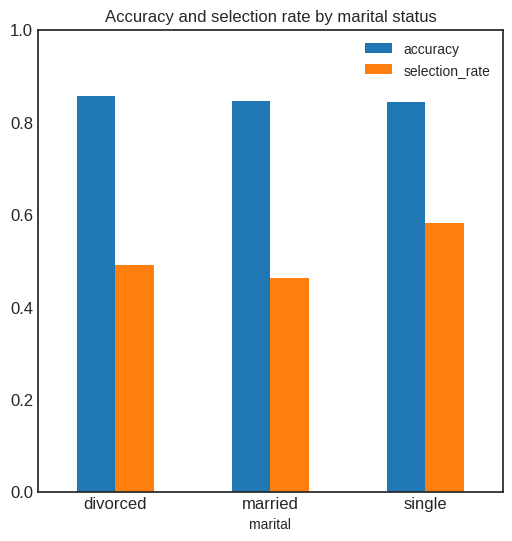

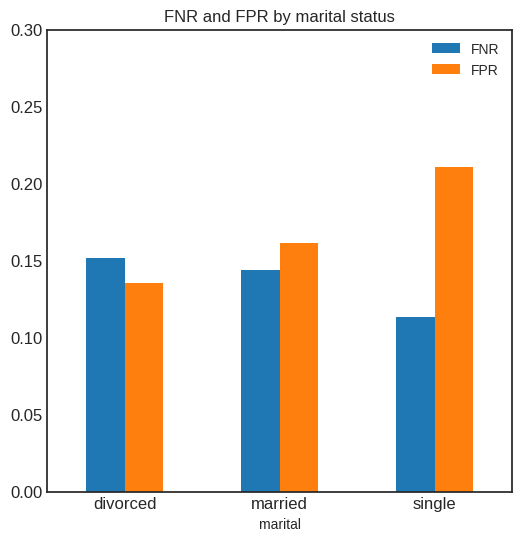

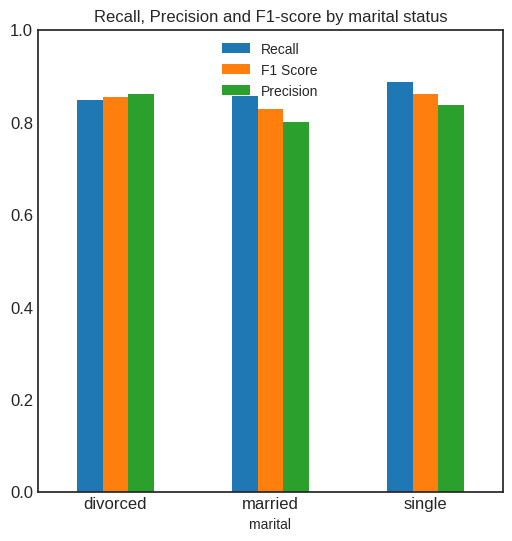

In [55]:
# Plot the metric values

metrics_1 = {'accuracy': skm.accuracy_score,
           'selection_rate': selection_rate,  # i.e., the percentage of the population which have ‘1’ as their predicted label
           }

metrics_2 = {
           'FNR': false_negative_rate,
           'FPR': false_positive_rate
           }

metrics_3 = {
           'Recall': recall_score,
           'F1 Score': f1_score,
           'Precision': precision_score
           }

grouped_on_edu_accuracy_selection = MetricFrame(metrics=metrics_1,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_feature_m)

grouped_on_edu_fpr_fnr = MetricFrame(metrics=metrics_2,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_feature_m)

grouped_on_edu_rec = MetricFrame(metrics=metrics_3,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_feature_m)

grouped_on_edu_accuracy_selection.by_group.plot.bar(
    subplots=False, 
    figsize=(6,6), 
    ylim=[0,1],
    title="Accuracy and selection rate by marital status",
    )
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

grouped_on_edu_fpr_fnr.by_group.plot.bar(
    subplots=False, 
    figsize=(6, 6), 
    ylim=[0,0.3],
    title="FNR and FPR by marital status",
    )
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

grouped_on_edu_rec.by_group.plot.bar(
    subplots=False, 
    figsize=(6,6), 
    ylim=[0,1],
    title="Recall, Precision and F1-score by marital status",
    )
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Calculating the Fairness Metrics across the sensitive feature - Age

In [56]:
conditions = [
    X_test['age'] <= 35,
    (X_test['age'] > 35) & (X_test['age'] <= 55),
    X_test['age'] > 55
]
values = ['Young', 'Middle-aged', 'Old']
X_test['age_cat'] = np.select(conditions, values)

In [57]:
#Getting the Fairness metrics for each sensitive feature-
#compute demographic parity difference and demographic parity ratio
demo_parity_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=X_test['age_cat'])
demo_parity_ratio = demographic_parity_ratio(y_test, y_pred, sensitive_features=X_test['age_cat'])

print(f'Demographic parity difference: {demo_parity_diff:.4f}')
print(f'Demographic parity ratio: {demo_parity_ratio:.4f}')

selection_rate_diff = selection_rate_difference(y_test, y_pred, sensitive_features=X_test['age_cat'])
equalized_odds_r = equalized_odds_ratio(y_test, y_pred, sensitive_features=X_test['age_cat'])

false_negative_rate_diff = false_negative_rate_difference(y_test, y_pred, sensitive_features=X_test['age_cat'])
false_positive_rate_diff = false_positive_rate_difference(y_test, y_pred, sensitive_features=X_test['age_cat'])

print(f'Selection Rate difference: {selection_rate_diff:.4f}')
print(f'Equalized odds ratio: {equalized_odds_r:.4f}')

print(f'False negative rate difference: {false_negative_rate_diff:.4f}')
print(f'False positive rate diff: {false_positive_rate_diff:.4f}')


#compute selection rate for males and females
# young_selection_rate = selection_rate(y_test[X_test['age_cat']=='Young'], y_pred[np.where(X_test['age_cat']=='Young')[0]])
# middle_aged_selection_rate = selection_rate(y_test[X_test['age_cat']=='Middle-aged'], y_pred[np.where(X_test['age_cat']=='Middle-aged')[0]])
# old_selection_rate = selection_rate(y_test[X_test['age_cat']=='Old'], y_pred[np.where(X_test['age_cat']=='Old')[0]])

# print(f'Young selection rate: {young_selection_rate:.4f}')
# print(f'Middle-aged selection rate: {middle_aged_selection_rate:.4f}')
# print(f'Old selection rate: {old_selection_rate:.4f}')

Demographic parity difference: 0.3029
Demographic parity ratio: 0.5754
Selection Rate difference: 0.3029
Equalized odds ratio: 0.3632
False negative rate difference: 0.0745
False positive rate diff: 0.2182


In [58]:
#Evaluate the fairness of the classifier using the MetricFrame class for the `Marital` variable

sensitive_feature_a = X_test['age_cat']

#evaluation metrics
metrics = {'accuracy': skm.accuracy_score,
           'selection_rate': selection_rate,  # i.e., the percentage of the population which have ‘1’ as their predicted label
           'FNR': false_negative_rate,
           'FPR': false_positive_rate,
           'Recall': recall_score,
           'F1 Score': f1_score,
           'Precision': precision_score
           }
           

grouped_on_age = MetricFrame(metrics=metrics,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_feature_a)

In [59]:
grouped_on_age.by_group

,accuracy,selection_rate,FNR,FPR,Recall,F1 Score,Precision
age_cat,,,,,,,
Middle-aged,0.861386,0.410441,0.159910,0.124438,0.840090,0.828889,0.817982
Old,0.824104,0.713355,0.085427,0.342593,0.914573,0.870813,0.831050
Young,0.834356,0.542331,0.130120,0.202500,0.869880,0.842474,0.816742


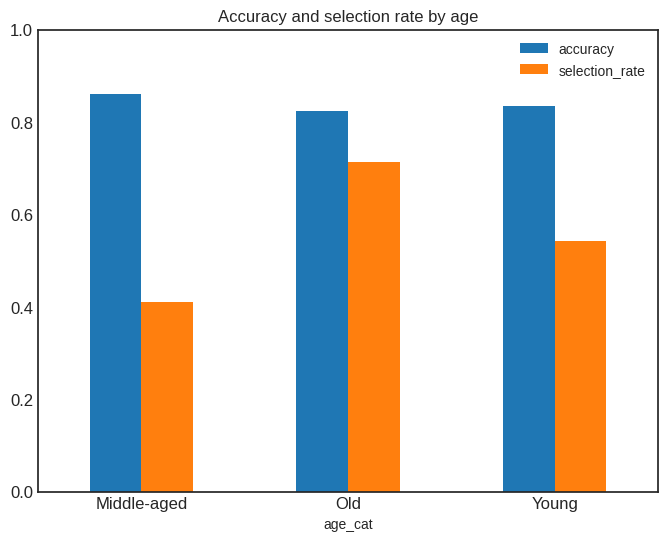

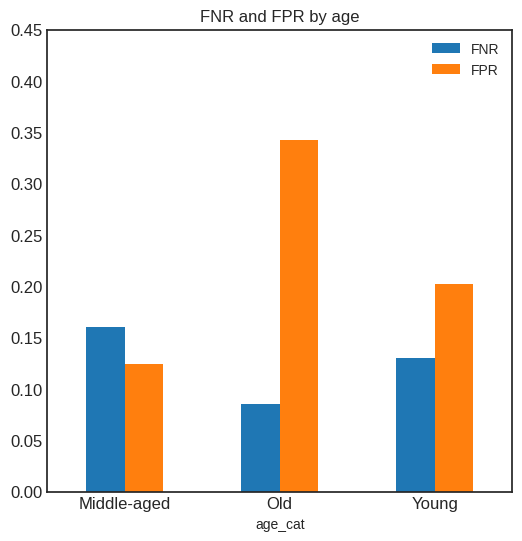

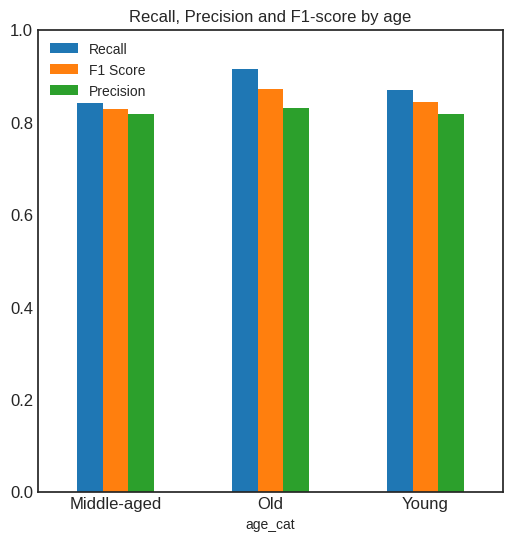

In [60]:
# Plot the metric values

metrics_1 = {'accuracy': skm.accuracy_score,
           'selection_rate': selection_rate,  # i.e., the percentage of the population which have ‘1’ as their predicted label
           }

metrics_2 = {
           'FNR': false_negative_rate,
           'FPR': false_positive_rate
           }

metrics_3 = {
           'Recall': recall_score,
           'F1 Score': f1_score,
           'Precision': precision_score
           }

grouped_on_edu_accuracy_selection = MetricFrame(metrics=metrics_1,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_feature_a)

grouped_on_edu_fpr_fnr = MetricFrame(metrics=metrics_2,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_feature_a)

grouped_on_edu_rec = MetricFrame(metrics=metrics_3,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_feature_a)

grouped_on_edu_accuracy_selection.by_group.plot.bar(
    subplots=False, 
    figsize=(8,6), 
    ylim=[0,1],
    title="Accuracy and selection rate by age",
    )
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

grouped_on_edu_fpr_fnr.by_group.plot.bar(
    subplots=False, 
    figsize=(6, 6), 
    ylim=[0,0.45],
    title="FNR and FPR by age",
    )
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

grouped_on_edu_rec.by_group.plot.bar(
    subplots=False, 
    figsize=(6,6), 
    ylim=[0,1],
    title="Recall, Precision and F1-score by age",
    )
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

#Baseline accuracy

In [61]:
# create a new column 'age_cat' using np.select
conditions = [
    df['age'] <= 35,
    (df['age'] > 35) & (df['age'] <= 55),
    df['age'] > 55
]
values = ['Young', 'Middle-aged', 'Old']
df['age_cat'] = np.select(conditions, values)

In [62]:
df['sensitive_att'] = df['age_cat'] + '_' + df['marital'] +'_' + df['education']

In [63]:
df['deposit_label'] = df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

In [64]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_cat,sensitive_att,deposit_label
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,Old,Old_married_secondary,1
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,Old,Old_married_secondary,1
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,Middle-aged,Middle-aged_married_secondary,1
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,Middle-aged,Middle-aged_married_secondary,1
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes,Middle-aged,Middle-aged_married_tertiary,1


In [65]:
baseline_acc = df.groupby('marital')['deposit_label'].mean()
print(baseline_acc.sort_values())
baseline_acc_marital = baseline_acc.apply(lambda x: 1 - x if x < 0.5 else x)
baseline_acc_marital.sort_values()

marital
married     0.433790
divorced    0.481052
single      0.543491
Name: deposit_label, dtype: float64


marital
divorced    0.518948
single      0.543491
married     0.566210
Name: deposit_label, dtype: float64

In [66]:
baseline_acc = df.groupby('education')['deposit_label'].mean()
print(baseline_acc.sort_values())
baseline_acc_edu = baseline_acc.apply(lambda x: 1 - x if x < 0.5 else x)
baseline_acc_edu.sort_values()

education
primary      0.394000
secondary    0.447407
unknown      0.507042
tertiary     0.541068
Name: deposit_label, dtype: float64


education
unknown      0.507042
tertiary     0.541068
secondary    0.552593
primary      0.606000
Name: deposit_label, dtype: float64

In [67]:
baseline_acc = df.groupby('age_cat')['deposit_label'].mean()
print(baseline_acc.sort_values())
baseline_acc_age = baseline_acc.apply(lambda x: 1 - x if x < 0.5 else x)
baseline_acc_age.sort_values()

age_cat
Middle-aged    0.413416
Young          0.500801
Old            0.610512
Name: deposit_label, dtype: float64


age_cat
Young          0.500801
Middle-aged    0.586584
Old            0.610512
Name: deposit_label, dtype: float64

### Baseline accuracy plots

In [68]:
data = {
    'baseline_acc_edu': {
        'tertiary': 0.541068,
        'secondary': 0.552593,
        'primary': 0.606000
    },
    'baseline_acc_age': {
        'Young': 0.500801,
        'Middle-aged': 0.586584,
        'Old': 0.610512
    },
    'baseline_acc_marital': {
        'divorced': 0.518948,
        'single': 0.543491,
        'married': 0.566210
    }
}
data = pd.DataFrame(data)

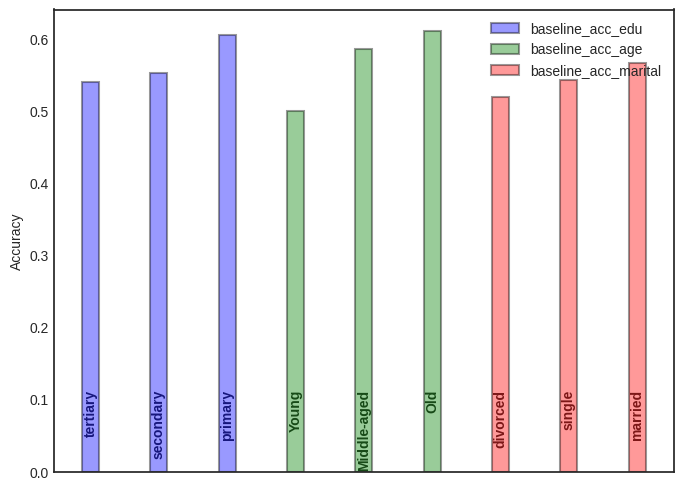

In [69]:
fig, ax = plt.subplots(figsize=(8, 6))
x_labels = []
x_ticks = []
width = 0.25

x_edu = list(data['baseline_acc_edu'][:3])
index_edu = list(data['baseline_acc_edu'].keys())[:3]
offset_edu = 0
ax.bar(index_edu, x_edu, width, label='baseline_acc_edu', alpha=0.4, color='b', edgecolor='k', linewidth=1.5, align='center')
x_labels += index_edu
x_ticks += index_edu
offset_edu += width

x_age = list(data['baseline_acc_age'][3:6])
index_age = list(data['baseline_acc_age'].keys())[3:6]
offset_age = offset_edu + width
ax.bar(index_age, x_age, width, label='baseline_acc_age', alpha=0.4, color='g', edgecolor='k', linewidth=1.5, align='center')
x_labels += index_age
x_ticks += index_age
offset_age += width

x_marital = list(data['baseline_acc_marital'][6:9])
index_marital = list(data['baseline_acc_marital'].keys())[6:9]
offset_marital = offset_age + width
ax.bar(index_marital, x_marital, width, label='baseline_acc_marital', alpha=0.4, color='r', edgecolor='k', linewidth=1.5, align='center')
x_labels += index_marital
x_ticks += index_marital

ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, fontweight='bold')
ax.set_ylabel('Accuracy')
ax.legend()

# Move the ticks inside the bars
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True, rotation=90, pad=-59)

plt.show()


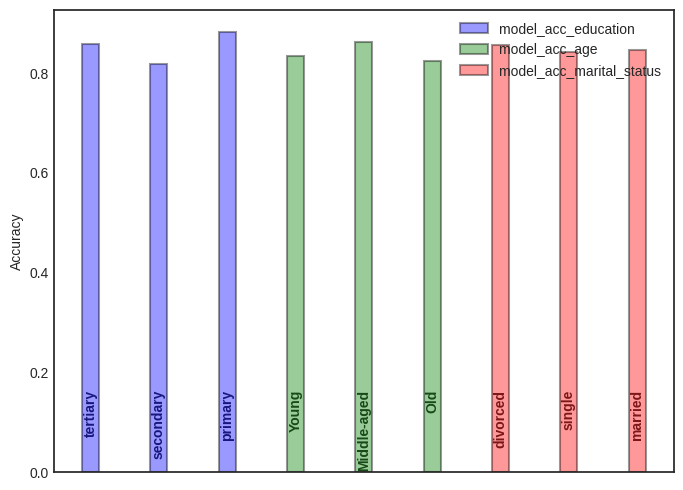

In [70]:
import matplotlib.pyplot as plt
import numpy as np

data = {
    'model_acc_edu': {
        'tertiary': 0.857015,
        'secondary': 0.816940,
        'primary': 0.882943
    },
    'model_acc_age': {
        'Young': 0.834356,
        'Middle-aged': 0.861386,
        'Old': 0.824104
    },
    'model_acc_marital': {
        'divorced': 0.856604,
        'single': 0.842663,
        'married': 0.846213
    }
}

data = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(8, 6))
x_labels = []
x_ticks = []
width = 0.25

x_edu = list(data['model_acc_edu'][:3])
index_edu = list(data['model_acc_edu'].keys())[:3]
offset_edu = 0
ax.bar(index_edu, x_edu, width, label='model_acc_education', alpha=0.4, color='b', edgecolor='k', linewidth=1.5, align='center')
x_labels += index_edu
x_ticks += index_edu
offset_edu += width

x_age = list(data['model_acc_age'][3:6])
index_age = list(data['model_acc_age'].keys())[3:6]
offset_age = offset_edu + width
ax.bar(index_age, x_age, width, label='model_acc_age', alpha=0.4, color='g', edgecolor='k', linewidth=1.5, align='center')
x_labels += index_age
x_ticks += index_age
offset_age += width

x_marital = list(data['model_acc_marital'][6:9])
index_marital = list(data['model_acc_marital'].keys())[6:9]
offset_marital = offset_age + width
ax.bar(index_marital, x_marital, width, label='model_acc_marital_status', alpha=0.4, color='r', edgecolor='k', linewidth=1.5, align='center')
x_labels += index_marital
x_ticks += index_marital

ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, fontweight='bold')
ax.set_ylabel('Accuracy')
ax.legend()

# Move the ticks inside the bars
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True, rotation=90, pad=-59)

plt.show()

